In [ ]:
pip install numpy nltk scikit-learn tensorflow matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')


In [ ]:
def load_text(path):
    texts = []
    labels = []
    with open(path, 'r') as file:
        txts = [x.split(';') for x in file.readlines()]
        for text, label in txts:
            texts.append(text)
            labels.append(label.rstrip('\n'))
    return texts, labels

In [ ]:
# Load training, validation, and testing data
train_texts, train_labels = load_text('reviews_train.txt')
val_texts, val_labels = load_text('reviews_val.txt') 
test_texts, test_labels = load_text('reviews_test.txt')   

In [ ]:
print("Training examples:", len(train_texts))
print("Validation examples:", len(val_texts))
print("Testing examples:", len(test_texts))

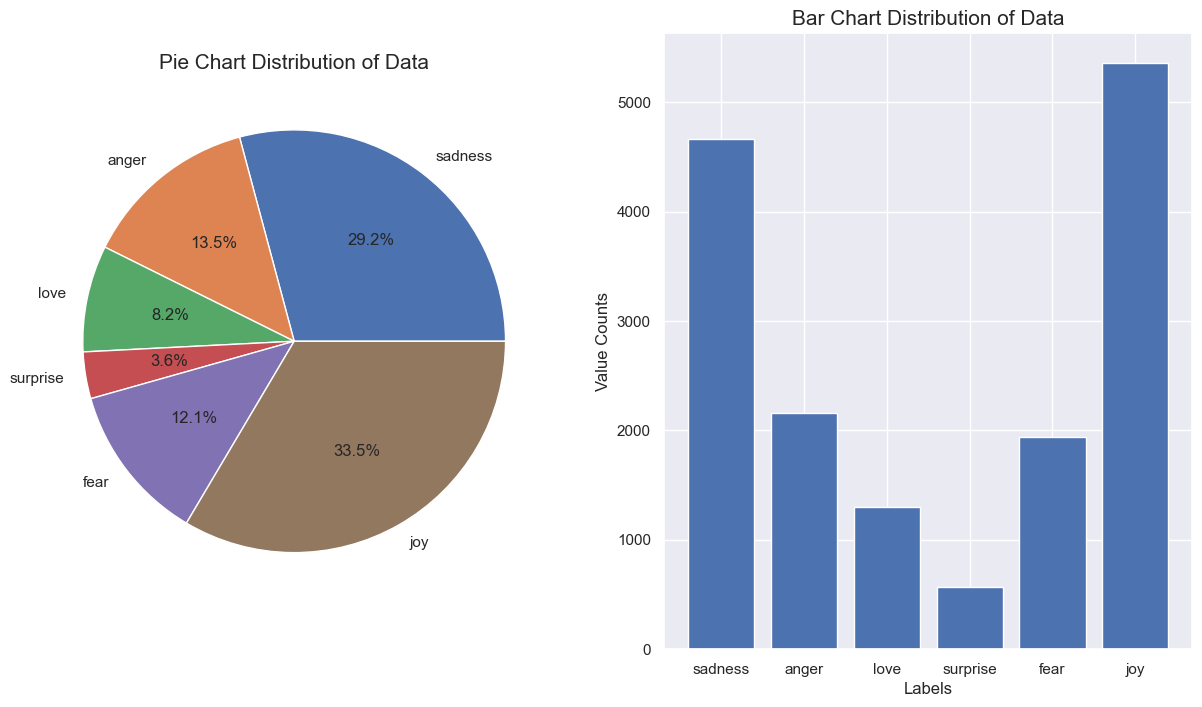

In [ ]:
# Visualize class distribution
classes_dict = Counter(train_labels)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].pie(classes_dict.values(), labels=classes_dict.keys(), autopct='%.1f%%')
ax[0].set_title("Pie Chart Distribution of Data", fontsize=15)
ax[1].bar(classes_dict.keys(), classes_dict.values())
ax[1].set_title("Bar Chart Distribution of Data", fontsize=15)
ax[1].set_xlabel("Labels")
ax[1].set_ylabel("Value Counts")
plt.show()

In [ ]:
def preprocess_texts(texts):
    stop_words = set(stopwords.words('english'))
    preprocessed_texts = []
    for text in texts:
        words = word_tokenize(text.lower())  # Tokenize text into words
        filtered_text = [word for word in words if word not in stop_words and word not in string.punctuation]
        preprocessed_texts.append(' '.join(filtered_text))
    return np.array(preprocessed_texts)

train_texts_p = preprocess_texts(train_texts)
val_texts_p = preprocess_texts(val_texts)
test_texts_p = preprocess_texts(test_texts)


In [ ]:
encoder = LabelEncoder()
train_labels_p = encoder.fit_transform(train_labels)
val_labels_p = encoder.transform(val_labels)
test_labels_p = encoder.transform(test_labels)


In [ ]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts_p)

train_seqs = tokenizer.texts_to_sequences(train_texts_p)
val_seqs = tokenizer.texts_to_sequences(val_texts_p)
test_seqs = tokenizer.texts_to_sequences(test_texts_p)

# Pad sequences
maxlen = max([len(x.split()) for x in train_texts_p])  # Determine max length
train_pad = pad_sequences(train_seqs, maxlen=maxlen)
val_pad = pad_sequences(val_seqs, maxlen=maxlen)
test_pad = pad_sequences(test_seqs, maxlen=maxlen)


In [ ]:
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100),
    LSTM(64, return_sequences=False),
    Dense(len(classes_dict), activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


In [ ]:
history = model.fit(
    train_pad, train_labels_p,
    validation_data=(val_pad, val_labels_p),
    epochs=8,
    batch_size=16,
    shuffle=True
)


In [ ]:
loss, accuracy = model.evaluate(test_pad, test_labels_p)
print("Test Loss:", loss)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))


In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Accuracy Plot
ax[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss Plot
ax[1].plot(history.history['loss'], label='Training Loss', color='blue')
ax[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
predictions = model.predict(test_pad)
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels_p, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_dict.keys(), yticklabels=classes_dict.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
def predict_emotion(text):
    processed_text = preprocess_texts([text])
    sequence = tokenizer.texts_to_sequences(processed_text)
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)
    prediction = model.predict(padded_sequence)
    predicted_label = np.argmax(prediction, axis=1)[0]
    emotion = encoder.inverse_transform([predicted_label])[0]
    return emotion

In [ ]:
# Array of better sample texts
sample_texts = [
    "I feel like I'm walking on air today! Everything feels so perfect and amazing.",
    "The anxiety is overwhelming, and I can't seem to shake the feeling of dread.",
    "I'm so proud of myself for accomplishing my goals! It feels like a dream come true.",
    "After hearing the tragic news, I feel completely heartbroken and empty inside.",
    "The joy of seeing my family again after such a long time apart is indescribable.",
    "I was so surprised when I got an unexpected gift from a friend I hadn't seen in years."
]

# Loop through the array and predict emotion for each text
for idx, text in enumerate(sample_texts):
    emotion = predict_emotion(text)  # Predict the emotion
    print(f"Text {idx + 1}: {text}")
    print(f"Predicted Emotion for text {idx + 1}: {emotion}\n")


In [ ]:
import pickle

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save model
model.save('emotion_recognizer.h5')
